<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from autograd import numpy as np
from autograd import grad
from autograd.misc.flatten import flatten_func
import copy

In [2]:
# compute C linear combinations of input point, one per classifier 
def model(x,w):
    a = w[0] + np.dot(x.T,w[1:]) 
    return a.T

# def perceptron_exp(x, y, w): 
#     model_res = model(x, w) 
#     return y * model_res

# def softmax_approx(w):
#     log_cost = np.log(1 + np.exp(-1 * perceptron_exp(x, y, w))) 
#     cost = np.sum(log_cost)
#     return cost

#  # the convex softmax cost function
# def softmax(xp, w):
#     cost = np.sum(np.log(1 + np.exp(-y*model(xp,w)))) 
#     return cost/float(np.size(y))

# def softmax_global(w): 
#     return softmax(x, w)
def perceptron_exp(x, y, w): 
    model_res = model(x, w) 
    return y * model_res

def perceptron(w):
    perceptron_res = perceptron_exp(x, y, w) 
    # perceptron_res shape = (1, 100) 
    neg_perceptron = -1 * perceptron_res
    
    # create a zero vector
    zeros = np.zeros(perceptron_res.size).reshape(perceptron_res.shape)
    # choose the maximum element between the two vectors
    gw = np.maximum(zeros, neg_perceptron) 
    return np.sum(gw)/float(np.size(y))

# multiclass perceptron
lam = 10**-5 # our regularization paramter 
def multiclass_perceptron(w):
    # pre-compute predictions on all points
    all_evals = model(x,w)
    
    # compute maximum across data points
    a = np.max(all_evals,axis = 0)
    
    # compute cost in compact form using numpy broadcasting
    b = all_evals[y.astype(int).flatten(),np.arange(np.size(y))] 
    cost = np.sum(a - b)
    
    # add regularizer
    cost = cost + lam*np.linalg.norm(w[1:,:],'fro')**2
    
    # return average
    # print("a", a, "b", b, "cost", cost)
    return cost/float(np.size(y))

# gradient descent function 
def gradient_descent(g,alpha,max_its,w):
    # compute gradient module using autograd
    gradient = grad(g)

    # run the gradient descent loop
    weight_history = [w] # weight history container
    cost_history = [g(w)] # cost function history container
    for k in range(max_its):
        # evaluate the gradient
        grad_eval = gradient(w)

        # take gradient descent step
        w = w - alpha*grad_eval
        
        # record weight and cost
        weight_history.append(w)
        cost_history.append(g(w))
    return weight_history,cost_history

def get_histories(fn, max_its, w, min_alpha=3, max_alpha=1, alpha_scale=1):
    labels = []
    cost_histories = []
    weight_histories = []
    for i in range(max_alpha, min_alpha+1):
      alpha = 10**(-i) * alpha_scale
      labels.append(r'$\alpha=10^{-%s}$' % str(i))
      weight_hist, cost_hist = gradient_descent(fn, alpha, max_its, w)
      cost_histories.append(cost_hist)
      weight_histories.append(weight_hist)
    return cost_histories, weight_histories, labels

# cost function history plotter
def plot_cost_histories(cost_histories,labels): 
    # create figure
    plt.figure() # 1, figsize=(10, 6))  
    # loop over cost histories and plot each one
    for j in range(len(cost_histories)): 
        history = cost_histories[j] 
        label = labels[j] 
        xnum = len(history)
        x = list(range(xnum))
        plt.plot(history, label = label)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    
def number_misclassification(y, yfit): 
    miss_count = 0
    miss_index = []
    for i in range(np.size(y)):
        if y[0][i] != yfit[i]: 
            miss_count += 1
            miss_index.append(i)
    return miss_count, miss_index

def misclassification(miss_index, y, yfit):
    for index in miss_index:
        print("y", y[0][index], "yfit", yfit[index])
        
def accuracy(miss_count, ysize): 
    return 1 - miss_count/float(ysize)

def get_yfit(x, w, fn): 
    yfit = fn(model(x, w)) 
    return yfit

In [3]:
df_train = pd.read_csv("./traindata.csv", dtype=np.uint8)

In [4]:
df_train.head(3)

,id,0,1,2,3,4,5,6,7,8,...,775,776,777,778,779,780,781,782,783,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4


In [5]:
df_train.shape

(60000, 786)

In [6]:
df_imgs = df_train.drop(['label', 'id'], axis=1)
x_original = df_imgs.as_matrix().T

In [7]:
x_original.shape

(784, 60000)

In [8]:
y_original = df_train['label'].as_matrix()
y_original = y_original.reshape(1, 60000)
print("y_original shape: ", y_original.shape)

y_original shape:  (1, 60000)


In [9]:
# extract edge-based features
import data_transformer
x_original_edgebased_features = data_transformer.edge_transformer(x_original)   

print('shape of original input ', x_original.shape)
print('shape of transformed input ', x_original_edgebased_features.shape)

shape of original input  (784, 60000)
shape of transformed input  (1352, 60000)


In [10]:
# sample indices
# num_sample = 5000
# inds = np.random.permutation(y_original.shape[1])[:num_sample]
# x_sample = x_original_edgebased_features[:,inds]
# y_sample = y_original[:,inds]

In [11]:
x = x_original_edgebased_features
y = y_original
yset = list(set(y[0]))

N = x.shape[0]
w0 = 0.01 * np.random.randn(N + 1, 1)

# print(w0)
ydata = copy.deepcopy(y)

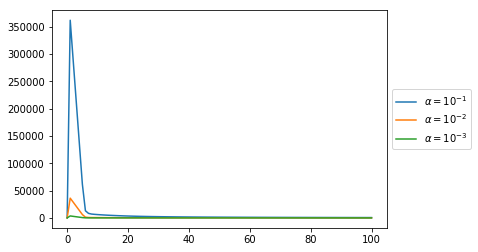

cost 6.54 y= 0 # miss 476


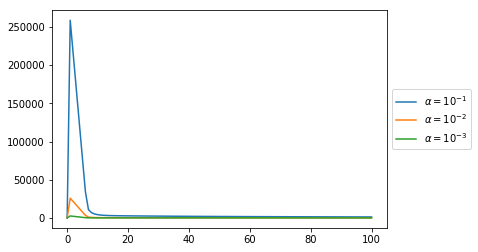

cost 12.82 y= 1 # miss 482


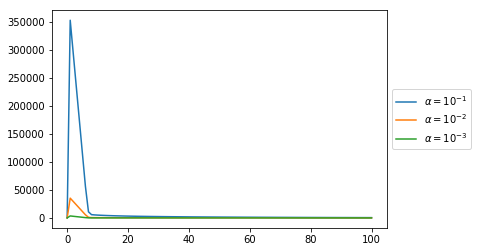

cost 5.49 y= 2 # miss 745


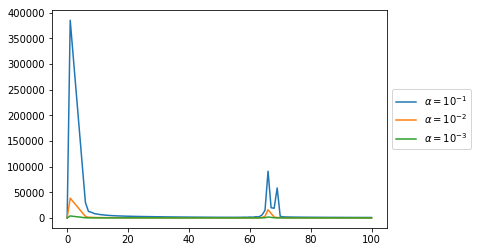

cost 10.98 y= 3 # miss 1012


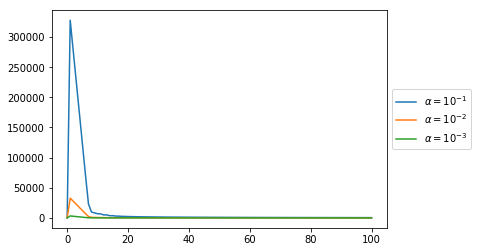

cost 4.81 y= 4 # miss 587


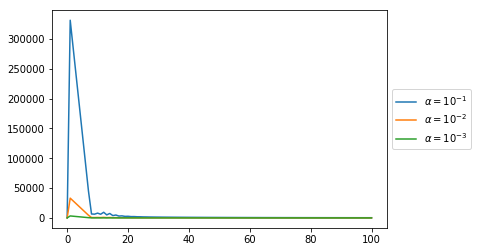

cost 3.21 y= 5 # miss 585


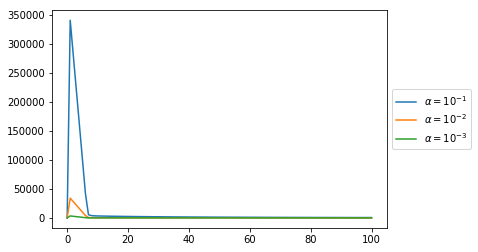

cost 6.10 y= 6 # miss 491


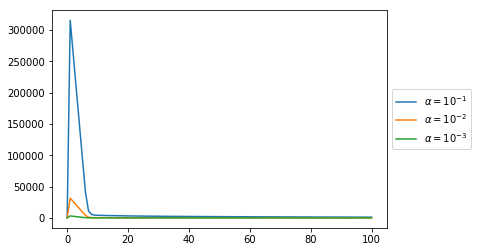

cost 11.95 y= 7 # miss 788


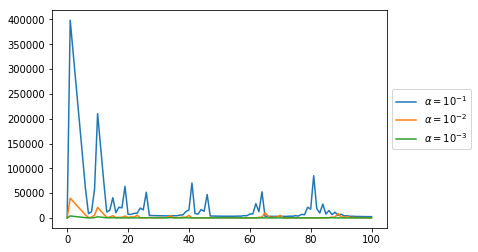

cost 24.53 y= 8 # miss 1610


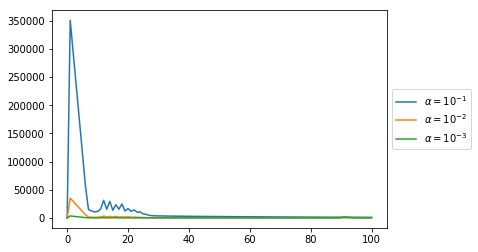

cost 74.01 y= 9 # miss 3316


In [12]:
weight_lst = []

for element, index in enumerate(yset):
    y = np.array(ydata, dtype=np.float_)
    y[element != y] = -1
    y[element == y] = 1
    cost_hist, weight_hist, labels = get_histories(perceptron, 
                                                   100, 
                                                   w0, min_alpha=3, max_alpha=1)
    plot_cost_histories(cost_hist, labels)
    weight_lst.append(weight_hist[-1][-1])
    yfit = get_yfit(x, weight_hist[-1][-1], np.sign)
    miss_count, _ = number_misclassification(y, yfit[0])
    print("cost %.2f" % (cost_hist[-1][-1]),
          "y=", element, 
          "# miss", miss_count) # , 
          # "weight", weight_hist[0][-1])

In [13]:
print("weight_lst len:", len(weight_lst))
print("weight_lst[0] shape:", weight_lst[0].shape)
w = np.empty((x.shape[0]+1, 0), dtype=float)

for weight in weight_lst:
    w = np.append(w, weight, axis=1)

print("w shape: ", w.shape)
yfit = model(x, w)
yfit = np.argmax(yfit, axis=0)
miss_count, _ = number_misclassification(ydata, yfit)
print("miss_count", miss_count)
print("accuracy", accuracy(miss_count, np.size(y)))

weight_lst len: 10
weight_lst[0] shape: (1353, 1)
w shape:  (1353, 10)
miss_count 4189
accuracy 0.9301833333333334


In [14]:
df_testdata = pd.read_csv("./testdata.csv", dtype=np.uint8)
df_testdata.head(3)

,id,0,1,2,3,4,5,6,7,8,...,775,776,777,778,779,780,781,782,783,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [15]:
df_testimgs = df_testdata.drop(['label', 'id'], axis=1)
xtest = df_testimgs.as_matrix().T
print("xtest shape:", xtest.shape)

xtest shape: (784, 10000)


In [16]:
xtest_edgebased_features = data_transformer.edge_transformer(xtest)

In [17]:
ytest = df_testdata['label'].as_matrix()
ytest = ytest.reshape((10000, 1)).T
print("ytest shape:", ytest.shape)

ytest shape: (1, 10000)


In [18]:
yfit_test = model(xtest_edgebased_features, w)
yfit_test = np.argmax(yfit_test, axis=0)
print("yfit_test shape:", yfit_test.shape)
print("yfit_test[0]:", yfit_test[0])
ytest[0][0]

miss_count, _ = number_misclassification(ytest, yfit_test)
raw_accuracy = accuracy(miss_count, np.size(ytest))
print("miss_count", miss_count)
print("accuracy:", raw_accuracy)

yfit_test shape: (10000,)
yfit_test[0]: 7
miss_count 640
accuracy: 0.9359999999999999
